# AdaptVQE for the Heisenberg Chain (obc) Hamiltonian
### Relevant literature:
- Basic adaptVQE algorithm (for fermionic systems) [[Grimsley et al., Nature 2019](https://www.nature.com/articles/s41467-019-10988-2)]
- Expansion to qubits (via Jordan Wigner trafo) [[Tang et al., PRX Quantum 2021](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.020310)]

- Tile-based adaptVQE approach [[Dyke et al., Phys. Rev. Res. 2024](https://link.aps.org/doi/10.1103/PhysRevResearch.6.L012030)]


### Main purpose is debugging:
- for small systems nq=5, the full operator pool gradients stall. Hard to say if this is expectable (since Mafaldas code base dependencies are broken, I can't check- quspin (which version?))
- but intuitively, as long as all calculations are accurate and feasible, the full operator pool should always be the best choice

In [32]:
using PauliPropagation
using Plots
using ReverseDiff
using ReverseDiff: GradientTape, gradient!, compile, gradient
using Bits
using Random
using Distributions: Uniform
using NLopt
using Optim

### 0) System and Initial State Construction

In [2]:
nq = 3

3

In [3]:
function heisenberg_1d_obc(nq::Int; topology = nothing)
    
    if isnothing(topology)
        topology = bricklayertopology(nq;periodic=false) #chain with obc
    end

    H = PauliSum(nq)
    for pair in topology
        add!(H, [:X,:X], collect(pair),1.0)
        add!(H, [:Y,:Y], collect(pair),1.0)
        add!(H, [:Z,:Z], collect(pair),1.0)
    end
    return H
end

heisenberg_1d_obc (generic function with 1 method)

In [4]:
heisenberg_1d_obc(nq)

PauliSum(nqubits: 3, 6 Pauli terms:
 1.0 * XXI
 1.0 * ZZI
 1.0 * IXX
 1.0 * YYI
 1.0 * IZZ
 1.0 * IYY
)

In [5]:
function neel_bits(nq::Int; up_on_odd::Bool=true)
    if up_on_odd
        # |0101...> → "1" on even sites
        return collect(2:2:nq)
    else
        # |1010...> → "1" on odd sites
        return collect(1:2:nq)
    end
end

neel_bits (generic function with 1 method)

In [6]:
# example usage:
neel_bits(10; up_on_odd=true)

5-element Vector{Int64}:
  2
  4
  6
  8
 10

We calculate the overlap with the Neel state because it has a final overlap with the ground state (Neel state is classical limit of the ground state of the Heisenberg model).
The AFM ordering of the Neel state matches our parameter choice (J=1).

In [7]:
# customized overlap function
# since we are in the Heisenberg picture, we propagate observables and in the final step, calculate the overlap with the initial state
function overlapwithneel(operator, nq::Int; 
                           up_on_odd::Bool=true, 
                           params=nothing)
                           
    # Create Néel state bit representation: indices of "1" bits
    nb = neel_bits(nq; up_on_odd=up_on_odd)
    
    # Compute overlap with computational basis state
    return overlapwithcomputational(operator, nb)
end

overlapwithneel (generic function with 1 method)

### 1) Full Operator Pool (Hamiltonian-Independent)

In [8]:
function generate_full_bit_pool(nq::Int)
    # Choose appropriate UInt type based on number of qubits (same as PP does)
    # Work with bit representations directly (easier to manipulate)
    UIntType = if nq <= 4
        UInt8
    elseif nq <= 8
        UInt16
    elseif nq <= 16
        UInt32
    else
        UInt64
    end
    
    # Here, we generate all non-identity bit patterns (therefore -1), which gives the full operator pool.
    pool = UIntType[]
    for i in 1:(4^nq - 1)
        push!(pool, UIntType(i))
    end
    
    return pool
end

generate_full_bit_pool (generic function with 1 method)

In [9]:
# Function to convert bit representation to PauliString when needed
function bit_to_paulistring(bit_repr, nq)
    paulis = Symbol[]
    sites = Int[]
    
    for qubit in 1:nq #going from right to left in bitstring
        pauli_val = getpauli(bit_repr, qubit) # get pauli of qubit as 0,1,2,3
        #println("Qubit $qubit: Pauli value = $pauli_val")
        if pauli_val != 0  # Skip identity (0) since Paulis are initialised as identity by default
            pauli_symbol = [:I, :X, :Y, :Z][pauli_val + 1] # julia indexing starts at 1!
            push!(paulis, pauli_symbol)
            push!(sites, qubit)
        end
    end
    
    return PauliString(nq, paulis, sites, 1.0), paulis, sites
end

bit_to_paulistring (generic function with 1 method)

### 2) AdaptVQE Elements and Tests

In [10]:
"""
    calc_gradients(bit_pool, H, nq;
                   circuit=nothing, params=nothing,
                   tol=1e-12, verbose=false, up_on_odd=true)

ADAPT-VQE gradients with in-place propagation:
g_P = ⟨φ₀ | [U† H U, U† P U] i | φ₀⟩, where |φ₀⟩ is the Néel state
selected by `up_on_odd`.
"""
function calc_gradients(bit_pool, H, nq;
                        circuit::Union{Nothing,Any}=nothing,
                        params::Union{Nothing,AbstractVector}=nothing,
                        tol::Float64=1e-12,
                        verbose::Bool=false,
                        up_on_odd::Bool=true)

    grads = Float64[]

    # Pre-propagate H once: H_prop = U† H U (only if a circuit is provided)
    H_prop = H
    if circuit !== nothing
        H_prop = deepcopy(H)                 # avoid mutating H
        propagate!(circuit, H_prop, params)  # in-place propagation
    end

    # For each pool element, pre-propagate P (to P_prop) and form [H_prop, P_prop]
    for (k, bit_repr) in enumerate(bit_pool)
        P= bit_to_paulistring(bit_repr, nq)[1]
        psum = PauliSum(nq)
        P = add!(psum, P) # PP works with PauliSums (see datatypes example notebook)
        #println("Calculating gradient for op[$k]: ", P)

        P_prop = P
        if circuit !== nothing
            P_prop = deepcopy(P)                 # avoid mutating the pool op
            propagate!(circuit, P_prop, params)  # in-place propagation
        end
        
        C = commutator(H_prop, P_prop) 
        if !(iterate(C) !== nothing)           # if the commutator is empty 
            verbose && println("op[$k]: ", P, "  commutator=0  → grad=0.0")
            push!(grads, 0.0)
            continue
        end
        g = overlapwithneel(im * C, nq; up_on_odd=up_on_odd)
        if abs(imag(g)) > tol
            @warn "Gradient has non-negligible imaginary part" imag=imag(g) op=P
        end

        push!(grads, real(g))
        verbose && println("op[$k]: ", P, "  grad=", real(g))
    end

    return grads
end

calc_gradients

In [11]:
# example usage
grads = calc_gradients(generate_full_bit_pool(nq), heisenberg_1d_obc(nq), nq; verbose=false, up_on_odd=true)

63-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
 -4.0
  0.0
  0.0
  4.0
  0.0
  ⋮
  0.0
  0.0
  4.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [12]:
function pick_top_operator(gradients::AbstractVector, operators::AbstractVector; rng=Random.GLOBAL_RNG)
    length(gradients) == length(operators) || throw(ArgumentError("gradients and operators must have same length"))
    isempty(gradients) && throw(ArgumentError("gradients must not be empty"))
    
    mags = abs.(gradients)
    order = sortperm(mags, rev=true)  # indices sorted by |grad| descending (following the nature paper implementation)
    gradients_sorted = gradients[order]
    operators_sorted = operators[order]

    max_mag = mags[order[1]]
    tied_top = filter(i -> mags[i] == max_mag, order)

    chosen_idx = rand(rng, tied_top)

    return operators[chosen_idx], gradients[chosen_idx], gradients_sorted, operators_sorted
end

pick_top_operator (generic function with 1 method)

In [13]:
# example usage:
top_op, top_grad, grads_sorted, ops_sorted = pick_top_operator(grads, generate_full_bit_pool(nq))
println("Top operator: ", bit_to_paulistring(top_op,nq)[1], " with gradient ", top_grad)
println("Top gradient: ", grads_sorted) # we ignore the signs when sorting

Top operator: PauliString(nqubits: 3, 1.0 * ZYX) with gradient 4.0
Top gradient: [-4.0, 4.0, 4.0, 4.0, -4.0, -4.0, -4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [14]:
function check_convergence(gradients; tol=1e-4)
    max_grad = maximum(abs.(gradients))
    return max_grad < tol, max_grad
end

check_convergence (generic function with 1 method)

In [15]:
# example usage:
check_convergence(grads; tol=1e-4)

(false, 4.0)

In [16]:
function pauli_rotation_from_bits(bit_repr, nq)
    _, paulis, sites = bit_to_paulistring(bit_repr, nq) 
    return PauliRotation(paulis, sites)
end

pauli_rotation_from_bits (generic function with 1 method)

In [17]:
# example usage:
pauli_rotation_from_bits(top_op,nq)

PauliRotation([:Z, :Y, :X], [1, 2, 3])

In [18]:
function append_from_bits!(circuit, thetas, chose_op, nq; theta_init=rand())
    gate = pauli_rotation_from_bits(chose_op, nq)
    pushfirst!(circuit, gate)
    pushfirst!(thetas, theta_init) # no factor of 2, we choose theta_init directly
    return circuit, thetas    # index of the new parameter
end

append_from_bits! (generic function with 1 method)

In [19]:
# example usage:
circuit = Any[]      # initialize the adaptVQE circuit
thetas  = Float64[]  # initialize the parameter list
circuit, thetas = append_from_bits!(circuit,thetas,top_op,nq; theta_init = 0.2)

(Any[PauliRotation([:Z, :Y, :X], [1, 2, 3])], [0.2])

In [20]:
function fulllossfunction(thetas, circuit, nq;topology = nothing, max_freq = Inf, max_weight = Inf)

    if isnothing(topology)
        topology = bricklayertopology(nq;periodic=false) #chain with obc
    end

    # differentiation libraries use custom types to trace through the computation
    # we need to make all of our objects typed like that so that nothing breaks
    CoeffType = eltype(thetas)

    H = PauliSum(CoeffType, nq)

    for pair in topology
        add!(H, [:X,:X], collect(pair),CoeffType(1.0))
        add!(H, [:Y,:Y], collect(pair),CoeffType(1.0))
        add!(H, [:Z,:Z], collect(pair),CoeffType(1.0))
    end

    # wrap the coefficients into PauliFreqTracker so that we can use `max_freq` truncation.
    # usually this happens automatically but the in-place propagate!() function does not allow that.
    wrapped_H = wrapcoefficients(H, PauliFreqTracker)
    
    # we also need to run the in-place version with `!`, because by default we copy the Pauli sum
    output_H = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight);
    return overlapwithneel(output_H,nq)
end

fulllossfunction (generic function with 1 method)

In [21]:
# Gradient Descent
function gd(thetas_init, closed_lossfunction, nq; eta=0.01, steps=200)
    
    #check out automatic diff example notebook for more details
    # some inputs and work buffer to play around with
    grad_array_compiled = similar(thetas_init);

    # pre-record a GradientTape for `gradsimulation` using inputs of length m with Float64 elements
    simulation_tape = GradientTape(closed_lossfunction, thetas_init)
    compiled_tape = compile(simulation_tape)
    
    opt_energy_gd = []
    thetas = copy(thetas_init)
    for i in 1:steps 
        gradient!(grad_array_compiled, compiled_tape, thetas)
        thetas .-= eta * grad_array_compiled
        opt_energy_gd = push!(opt_energy_gd, closed_lossfunction(thetas)/nq)
    end
    return thetas, opt_energy_gd
end

gd (generic function with 1 method)

In [22]:
# Adam optimizer
function adam(thetas_init, closed_lossfunction, nq; eta=0.02, steps=100)
    nparams = length(thetas_init)

 
   # ReverseDiff tape on the tied loss (same as GD system)
    tape = GradientTape(closed_lossfunction, thetas_init)
    compiled_tape = compile(tape)

    # Buffers & Adam state
    grad = similar(thetas_init)
    thetas = copy(thetas_init)
    opt_energy = Vector{Float64}(undef, 0)

    m = zero(thetas); v = zero(thetas)
    β1, β2, ϵ = 0.9, 0.999, 1e-8

    for t in 1:steps
        gradient!(grad, tape, thetas)

        # Adam update
        m .= β1 .* m .+ (1 - β1) .* grad
        v .= β2 .* v .+ (1 - β2) .* (grad .^ 2)
        mhat = m ./ (1 - β1^t)
        vhat = v ./ (1 - β2^t)
        thetas .-= eta .* mhat ./ (sqrt.(vhat) .+ ϵ)

        # Log E/Q using the tied view
        push!(opt_energy, closed_lossfunction(thetas)/nq)
    end
    return thetas, opt_energy
end


adam (generic function with 1 method)

In [ ]:
# L-BFGS optimizer using NLopt package
# https://nlopt.readthedocs.io/en/latest/NLopt_Reference/
function lbfgs_nlopt(thetas_init, closed_lossfunction, nq;
                     max_iters=500, xtol_rel=1e-8, ftol_rel=1e-12, # max_iters is the max function evaluations, not iterations (we can have multiple within one iteration)
                     max_time=Inf,
                     lower_bounds=nothing, upper_bounds=nothing,
                     verbose=false)

    n  = length(thetas_init)

    # ReverseDiff: compile once, reuse
    tape     = GradientTape(closed_lossfunction, thetas_init) #assume thetas_init is already Float64
    compiled_tape = compile(tape)
    gbuf     = zeros(n) # gradient buffer (preallocated), we need this for type stability between NLopt (C library) and Julia
    opt_energy = Float64[]
    evals = Ref(0) # function (gradient) evaluations

    # warm start nudge
    x0 = copy(thetas_init)

    gradient!(gbuf, compiled_tape, x0)
    if all(iszero, x0) && any(!iszero, gbuf)
        η = min(1e-1, 0.1 / (sqrt(sum(abs2, gbuf)) + 1e-12))  # scale with ‖g‖
        x0 .-= η .* gbuf
    end

    opt = Opt(:LD_LBFGS, n) # NLopt package for L-BFGS algorithm
    NLopt.maxeval!(opt, max_iters) # maximum number of function evaluations
    #NLopt.xtol_rel!(opt, xtol_rel) # relative tolerance on optimization parameters (x axis)
    #NLopt.ftol_rel!(opt, ftol_rel) # relative tolerance on function value (f(x) axis)
    NLopt.maxtime!(opt, isfinite(max_time) ? max_time : 0.0) # maximum time in seconds (0.0 means no cap)

    # Emulate dense BFGS by keeping a very large history:
    # choose >= expected #iterations/evals. Using max_iters is a simple upper bound.
    NLopt.vector_storage!(opt, max_iters)


    # give the line search a sensible first step size
    NLopt.initial_step!(opt, fill(1e-1, n)) 


    # using these causes an error! (we're bounding the thetas during the adaptVQE anyways, so this is not necessarily needed - and this can hinder optimization)
    if lower_bounds !== nothing
        NLopt.lower_bounds!(opt, Float64.(lower_bounds))
    end
    if upper_bounds !== nothing
        NLopt.upper_bounds!(opt, Float64.(upper_bounds))
    end

    NLopt.min_objective!(opt, (x, grad) -> begin # grad is write only that belongs to NLopt, sometimes NLopt wont ask for it, then it passes an empty array
        fx = closed_lossfunction(x) :: Float64
        if !isempty(grad)
            gradient!(gbuf, compiled_tape, x) # ReverseDiff writes gradient into gbuf, then we copy into grad
            @inbounds @simd for i in 1:n
                grad[i] = gbuf[i]
            end
        end
        evals[] += 1
        push!(opt_energy, fx)
        return fx
    end)

    minf, thetas, ret = NLopt.optimize(opt, x0) # minf is best function / objective value found, thetas is the best params (that give minf), ret is termination code.
    if verbose
        @info "NLopt LBFGS terminated" status=ret evals=evals[] fmin=minf
    end

    return thetas, opt_energy/nq # LLBFGS can do multiple function evaluations per iteration, so length(opt_energy) tracks evaluations (≤ max_iters), not iterations.
end


lbfgs_nlopt (generic function with 1 method)

In [47]:

function lbfgs_optim(
    thetas_init, closed_lossfunction, nq;
    max_iters::Int=500,
    g_tol::Float64=1e-8,
    x_abstol::Union{Nothing,Float64}=1e-8,
    x_reltol::Union{Nothing,Float64}=nothing,
    f_abstol::Union{Nothing,Float64}=nothing,
    f_reltol::Union{Nothing,Float64}=1e-12,
    max_time::Real=Inf,
    lower_bounds=nothing, upper_bounds=nothing,
    verbose::Bool=false
)
    x0 = Float64.(thetas_init)

    # ReverseDiff tape
    tape  = ReverseDiff.GradientTape(closed_lossfunction, x0)
    ctape = ReverseDiff.compile(tape)

    f(x) = closed_lossfunction(x)::Float64
    g!(G, x) = (ReverseDiff.gradient!(G, ctape, x); nothing)

    energy_hist = Float64[]
    cb = state -> (push!(energy_hist, Optim.value(state)); false)

    # Build Optim.Options without deprecated fields
    kw = Dict{Symbol,Any}(
        :g_tol => g_tol,
        :iterations => max_iters,
        :show_trace => verbose,
        :show_every => 1,
    )
    if x_abstol !== nothing; kw[:x_abstol] = x_abstol; end
    if x_reltol !== nothing; kw[:x_reltol] = x_reltol; end
    if f_abstol !== nothing; kw[:f_abstol] = f_abstol; end
    if f_reltol !== nothing; kw[:f_reltol] = f_reltol; end
    if isfinite(max_time);  kw[:time_limit] = max_time;  end
    opts = Optim.Options(; kw...)

    algo = Optim.LBFGS()

    res = if lower_bounds === nothing || upper_bounds === nothing
        Optim.optimize(f, g!, x0, algo; callback=cb, options=opts)
    else
        lower = Float64.(lower_bounds); upper = Float64.(upper_bounds)
        Optim.optimize(f, g!, lower, upper, x0, Optim.Fminbox(algo); callback=cb, options=opts)
    end

    thetas = Optim.minimizer(res)
    return thetas, energy_hist ./ nq
end


lbfgs_optim (generic function with 1 method)

In [48]:
function target_optimization(nq, circuit, thetas; max_freq=Inf, max_weight=Inf, verbose = false)
    # again, automatic diff example notebook for more details
    closed_lossfunction = let const_nq=nq, const_max_freq=max_freq, const_max_weight=max_weight
        # these are now all captured variables with known types and we return a function that only takes thetas s.t. ReverseDiff works
        # See also "closures"
        theta -> fulllossfunction(theta, circuit, const_nq; max_freq=const_max_freq, max_weight=const_max_weight)
    end

    opt_thetas, opt_energy_opt = lbfgs_optim(thetas,closed_lossfunction,nq; verbose=verbose)
    #opt_thetas, opt_energy_opt = lbfgs_nlopt(thetas,closed_lossfunction,nq; verbose=verbose)
    #opt_thetas, opt_energy_opt = adam(thetas,closed_lossfunction,nq; eta=0.02, steps=200)
    #opt_thetas, opt_energy_opt = gd(thetas,closed_lossfunction,nq; eta=0.01, steps=200)
    
    if verbose
        println("Optimized thetas: ", opt_thetas)
        println("Optimized energy per qubit: ", opt_energy_opt[end])
        plot(opt_energy_opt)
        display(plot!(title = "Energy optimisation", xlabel = "runs", ylabel = "E/Q"))
    end

    return opt_thetas, opt_energy_opt
end

target_optimization (generic function with 1 method)

### 3) AdaptVQE Loop

In [49]:
function adaptVQE_loop(nq, hamiltonian, bit_pool; max_iters=10, conv_tol=1e-4, verbose=true)
    circuit = Any[]      # initialize the adaptVQE circuit
    thetas  = Float64[]; # initialize the parameter list
    energy_per_loop = Float64[];
    max_grads = Float64[] # collect for analysis
    chosen_ops = UInt[]

    for iter in 1:max_iters
        println("=== ADAPT-VQE iteration $iter ===")
        # 1) Calculate gradients
        grads = calc_gradients(bit_pool, hamiltonian, nq; circuit=circuit, params=thetas, tol=1e-12, verbose=false, up_on_odd=true)

        # 2) Check convergence
        converged, max_grad = check_convergence(grads; tol=conv_tol)
        push!(max_grads, max_grad)
        
        if converged
            println("Convergence achieved with max gradient < $conv_tol")
            break
        end

        # 3) Pick top operator
        chose_op, grad_op, grads_sorted, _ = pick_top_operator(grads, bit_pool)

        push!(chosen_ops, chose_op)

        # 4) Append operator to circuit
        theta_init = 0#rand(Uniform(-0.1,0.1)) # rand(Uniform(-π, π)) in PauliRotation gate (e^-i\theta/2 P, so [-pi,pi] covers the Blochsphere)
        circuit, thetas = append_from_bits!(circuit, thetas, chose_op, nq; theta_init=theta_init) # theta_init is multiplied by 2 in append function
        println("circuit: ", circuit)
        println("before thetas: ", thetas)
        # 5) Optimize parameters'
        thetas, opt_energy_gd = target_optimization(nq, circuit, thetas; verbose=verbose)

        println("opt thetas: ", thetas)
        # wrap the thetas to [-π,π] since they are angles if the optimization brought us out (periodicity of Bloch Sphere)
        thetas = rem2pi.(thetas, RoundNearest) # does not seem to help the optimization
        println("constrained thetas: ", thetas)
        push!(energy_per_loop, opt_energy_gd[end])
    end

    # 6) Plot the gradient convergence
    if verbose
        plot(max_grads, marker=:o)
        display(plot!(title = "Max Gradient Convergence", xlabel = "Iteration", ylabel = "Max Gradient"))
    end

    return circuit, thetas, chosen_ops, energy_per_loop, max_grads
end

adaptVQE_loop (generic function with 1 method)

### Test Run

In [50]:
nq = 3
hamiltonian = heisenberg_1d_obc(nq; topology=bricklayertopology(nq;periodic=false))
full_bit_pool = generate_full_bit_pool(nq)
circuit, thetas, chosen_ops, energy_per_loop, max_grads = adaptVQE_loop(nq, hamiltonian, full_bit_pool; max_iters=20, conv_tol=1e-4, verbose=true);

=== ADAPT-VQE iteration 1 ===
circuit: Any[PauliRotation([:Y, :X], [2, 3])]
before thetas: [0.0]


MethodError: MethodError: no method matching optimize(::var"#f#67"{var"#71#72"{Vector{Any}, Int64, Float64, Float64}}, ::var"#g!#68"{ReverseDiff.CompiledTape{GradientTape{var"#71#72"{Vector{Any}, Int64, Float64, Float64}, ReverseDiff.TrackedArray{Float64, Float64, 1, Vector{Float64}, Vector{Float64}}, ReverseDiff.TrackedReal{Float64, Float64, Nothing}}}}, ::Vector{Float64}, ::LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Returns{Nothing}}, ::Optim.Options{Float64, Nothing}; callback::var"#66#69"{Vector{Float64}}, options::Optim.Options{Float64, Nothing})
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

Closest candidates are:
  optimize(::Any, ::Any, ::AbstractArray, ::Optim.AbstractOptimizer, ::Optim.Options; inplace, autodiff) got unsupported keyword arguments "callback", "options"
   @ Optim ~/.julia/packages/Optim/7krni/src/multivariate/optimize/interface.jl:289
  optimize(::Any, !Matched::NLSolversBase.AbstractConstraints, ::AbstractArray, ::Optim.AbstractOptimizer, ::Optim.Options; inplace, autodiff) got unsupported keyword arguments "callback", "options"
   @ Optim ~/.julia/packages/Optim/7krni/src/multivariate/optimize/interface.jl:276
  optimize(::Any, ::Any, ::AbstractArray, ::Optim.AbstractOptimizer; ...)
   @ Optim ~/.julia/packages/Optim/7krni/src/multivariate/optimize/interface.jl:289
  ...


In [27]:
println("size of full bit pool: ", size(full_bit_pool))

size of full bit pool: (63,)


In [28]:
println("Final thetas: ", thetas)

Final thetas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [29]:
energy_per_loop*nq# -1.333 is the ED result for 3 qubits, -1.6160254 ED for 4 qubits, -1.54230900265439 for 5 qubits.

20-element Vector{Float64}:
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0
 -2.0

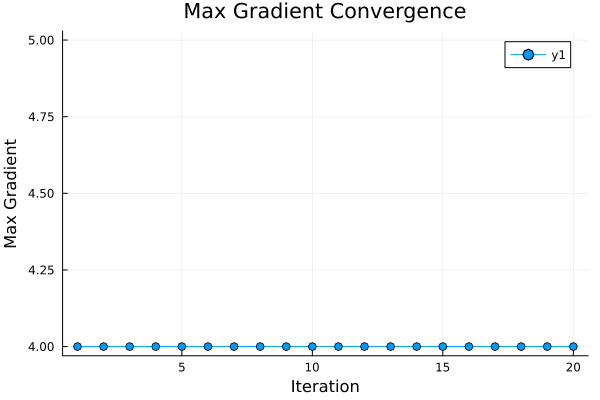

In [30]:
plot(max_grads, marker=:o)
plot!(title = "Max Gradient Convergence", xlabel = "Iteration", ylabel = "Max Gradient")

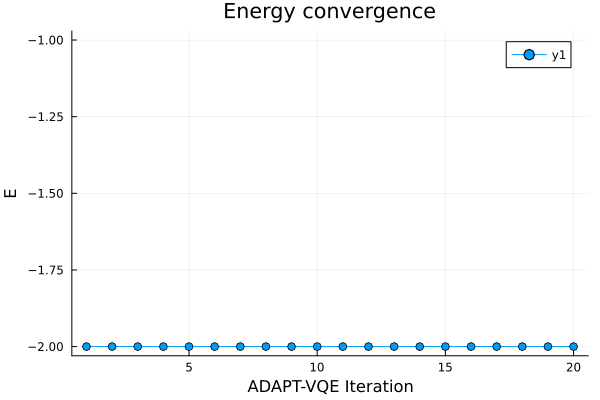

In [31]:
plot(energy_per_loop*nq, marker=:o)
plot!(title = "Energy convergence", xlabel = "ADAPT-VQE Iteration", ylabel = "E")